In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Setting up Data
import tensorflow as tf
from sklearn import preprocessing
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES']='1' 
tf.reset_default_graph()
%matplotlib inline

C:\E_Disk\anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#中冷后进气压力/进气量/ 中冷后进气温度/冷却水温度/ EGR阀开度/实测氧浓度/实测碳烟排放
data = pd.read_csv("../data/data_train.csv")
data = data.dropna()
data = data[['AIR_FLOW','CEXREAL','NE','PIM','QFIN','THA','THW','soot']]
print(data.shape)

(149503, 8)


In [3]:
#删除97000--100000范围的数据
data['soot'][97000:100000] = -1
data_la = data[data['soot'] != -1]
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
#f = lambda x : 20 if x>20 else x
#data2 = data['soot'].map(f)
data_la['soot'] = data_la['soot'].apply( lambda x: 0.1 if x<0.2 else x)
#data_la['soot'] = data_la['soot'].apply( lambda x: 20 if x>20 else x)
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
#data_la['soot'] = data_la['soot'].apply( lambda x: 0.2 if (x < 0.3) & (x >0.1) else x)  
#data_la['soot'] = data_la['soot'].apply( lambda x: 0.15 if x<0.3 else x)

C:\E_Disk\anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


C:\E_Disk\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """



 mu = 1.32 and sigma = 1.24



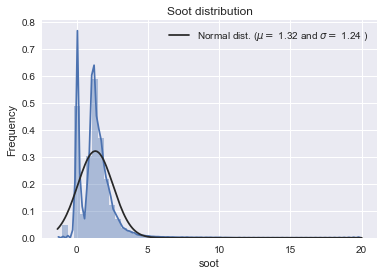

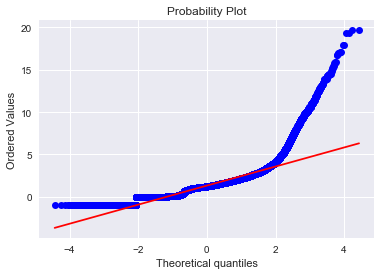

In [4]:
from scipy import stats
from scipy.stats import norm, skew
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
data_la['soot'] = np.log1p(data_la['soot'])

#Check the new distribution 
sns.distplot(data['soot'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['soot'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Soot distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['soot'], plot=plt)
plt.show()

In [5]:
features =  data_la.columns.values[0:7]   
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
data = data_la
n_train_days = int(len(data)*0.8)
data = data
#前80% 天的数据作为训练数据
train = data[:n_train_days]

#最后20%天的数据作为验证数据
test = data[n_train_days:]


In [6]:
#设定输入输出
train_X, train_y = train[features].values, train['soot'].values

test_X, test_y = test[features].values, test['soot'].values
from sklearn import  preprocessing
train_X = preprocessing.scale(train_X)
test_X = preprocessing.scale(test_X)
#数据转化为LSTM的输入数据类型（3D格式，【样本，时间步长，特征】）
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(117202, 1, 7) (117202,) (29301, 1, 7) (29301,)


In [7]:
#设计网络结构

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense
import matplotlib.pyplot  as plt
from keras.callbacks import TensorBoard 
from keras.layers import Dropout

#在第一个隐层中定义具有50个神经元的LSTM和用于预测close的
#输出层中的1个神经元，输入形状是1个时间步长，具有5个特征。
model = Sequential()
model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam',metrics = ['mae'])

#使用平均绝对误差（MAE）损失函数。该模型将拟合50个批量大小为64的
#训练时期。通过在fit（）函数中设置validation_data参数来跟踪训练
#过程中的训练和测试失败
#epochs和batch_size调了好长时间效果一直不好
history = model.fit(train_X, train_y, epochs=1000,batch_size=1200, validation_data=(test_X, test_y),verbose=2, shuffle=False)


Using TensorFlow backend.


Train on 117202 samples, validate on 29301 samples
Epoch 1/1000
 - 1s - loss: 0.5184 - mean_absolute_error: 0.5839 - val_loss: 0.3082 - val_mean_absolute_error: 0.4429
Epoch 2/1000
 - 1s - loss: 0.2199 - mean_absolute_error: 0.3714 - val_loss: 0.1516 - val_mean_absolute_error: 0.3131
Epoch 3/1000
 - 1s - loss: 0.1231 - mean_absolute_error: 0.2760 - val_loss: 0.0970 - val_mean_absolute_error: 0.2469
Epoch 4/1000
 - 1s - loss: 0.0874 - mean_absolute_error: 0.2268 - val_loss: 0.0805 - val_mean_absolute_error: 0.2184
Epoch 5/1000
 - 1s - loss: 0.0761 - mean_absolute_error: 0.2052 - val_loss: 0.0746 - val_mean_absolute_error: 0.2042
Epoch 6/1000
 - 1s - loss: 0.0715 - mean_absolute_error: 0.1944 - val_loss: 0.0713 - val_mean_absolute_error: 0.1956
Epoch 7/1000
 - 1s - loss: 0.0688 - mean_absolute_error: 0.1880 - val_loss: 0.0690 - val_mean_absolute_error: 0.1899
Epoch 8/1000
 - 1s - loss: 0.0670 - mean_absolute_error: 0.1835 - val_loss: 0.0673 - val_mean_absolute_error: 0.1857
Epoch 9/1000


 - 1s - loss: 0.0447 - mean_absolute_error: 0.1337 - val_loss: 0.0448 - val_mean_absolute_error: 0.1342
Epoch 71/1000
 - 1s - loss: 0.0446 - mean_absolute_error: 0.1335 - val_loss: 0.0451 - val_mean_absolute_error: 0.1353
Epoch 72/1000
 - 1s - loss: 0.0447 - mean_absolute_error: 0.1338 - val_loss: 0.0447 - val_mean_absolute_error: 0.1341
Epoch 73/1000
 - 1s - loss: 0.0445 - mean_absolute_error: 0.1332 - val_loss: 0.0449 - val_mean_absolute_error: 0.1347
Epoch 74/1000
 - 1s - loss: 0.0444 - mean_absolute_error: 0.1330 - val_loss: 0.0445 - val_mean_absolute_error: 0.1335
Epoch 75/1000
 - 1s - loss: 0.0442 - mean_absolute_error: 0.1325 - val_loss: 0.0445 - val_mean_absolute_error: 0.1336
Epoch 76/1000
 - 1s - loss: 0.0441 - mean_absolute_error: 0.1324 - val_loss: 0.0444 - val_mean_absolute_error: 0.1331
Epoch 77/1000
 - 1s - loss: 0.0440 - mean_absolute_error: 0.1322 - val_loss: 0.0443 - val_mean_absolute_error: 0.1331
Epoch 78/1000
 - 1s - loss: 0.0440 - mean_absolute_error: 0.1321 - val

Epoch 140/1000
 - 1s - loss: 0.0414 - mean_absolute_error: 0.1272 - val_loss: 0.0422 - val_mean_absolute_error: 0.1290
Epoch 141/1000
 - 1s - loss: 0.0413 - mean_absolute_error: 0.1268 - val_loss: 0.0422 - val_mean_absolute_error: 0.1290
Epoch 142/1000
 - 1s - loss: 0.0413 - mean_absolute_error: 0.1269 - val_loss: 0.0422 - val_mean_absolute_error: 0.1290
Epoch 143/1000
 - 1s - loss: 0.0413 - mean_absolute_error: 0.1269 - val_loss: 0.0421 - val_mean_absolute_error: 0.1289
Epoch 144/1000
 - 1s - loss: 0.0412 - mean_absolute_error: 0.1267 - val_loss: 0.0422 - val_mean_absolute_error: 0.1291
Epoch 145/1000
 - 1s - loss: 0.0412 - mean_absolute_error: 0.1270 - val_loss: 0.0420 - val_mean_absolute_error: 0.1288
Epoch 146/1000
 - 1s - loss: 0.0411 - mean_absolute_error: 0.1266 - val_loss: 0.0423 - val_mean_absolute_error: 0.1296
Epoch 147/1000
 - 1s - loss: 0.0414 - mean_absolute_error: 0.1279 - val_loss: 0.0421 - val_mean_absolute_error: 0.1294
Epoch 148/1000
 - 1s - loss: 0.0412 - mean_absol

Epoch 209/1000
 - 1s - loss: 0.0392 - mean_absolute_error: 0.1236 - val_loss: 0.0409 - val_mean_absolute_error: 0.1273
Epoch 210/1000
 - 1s - loss: 0.0394 - mean_absolute_error: 0.1245 - val_loss: 0.0407 - val_mean_absolute_error: 0.1269
Epoch 211/1000
 - 1s - loss: 0.0393 - mean_absolute_error: 0.1236 - val_loss: 0.0411 - val_mean_absolute_error: 0.1286
Epoch 212/1000
 - 1s - loss: 0.0396 - mean_absolute_error: 0.1255 - val_loss: 0.0407 - val_mean_absolute_error: 0.1274
Epoch 213/1000
 - 1s - loss: 0.0393 - mean_absolute_error: 0.1238 - val_loss: 0.0411 - val_mean_absolute_error: 0.1285
Epoch 214/1000
 - 1s - loss: 0.0393 - mean_absolute_error: 0.1244 - val_loss: 0.0406 - val_mean_absolute_error: 0.1267
Epoch 215/1000
 - 1s - loss: 0.0391 - mean_absolute_error: 0.1234 - val_loss: 0.0407 - val_mean_absolute_error: 0.1270
Epoch 216/1000
 - 1s - loss: 0.0391 - mean_absolute_error: 0.1237 - val_loss: 0.0406 - val_mean_absolute_error: 0.1266
Epoch 217/1000
 - 1s - loss: 0.0390 - mean_absol

Epoch 278/1000
 - 1s - loss: 0.0377 - mean_absolute_error: 0.1213 - val_loss: 0.0399 - val_mean_absolute_error: 0.1252
Epoch 279/1000
 - 1s - loss: 0.0376 - mean_absolute_error: 0.1211 - val_loss: 0.0399 - val_mean_absolute_error: 0.1251
Epoch 280/1000
 - 1s - loss: 0.0376 - mean_absolute_error: 0.1211 - val_loss: 0.0399 - val_mean_absolute_error: 0.1252
Epoch 281/1000
 - 1s - loss: 0.0376 - mean_absolute_error: 0.1211 - val_loss: 0.0399 - val_mean_absolute_error: 0.1252
Epoch 282/1000
 - 1s - loss: 0.0376 - mean_absolute_error: 0.1211 - val_loss: 0.0399 - val_mean_absolute_error: 0.1252
Epoch 283/1000
 - 1s - loss: 0.0376 - mean_absolute_error: 0.1210 - val_loss: 0.0399 - val_mean_absolute_error: 0.1252
Epoch 284/1000
 - 1s - loss: 0.0376 - mean_absolute_error: 0.1211 - val_loss: 0.0399 - val_mean_absolute_error: 0.1252
Epoch 285/1000
 - 1s - loss: 0.0375 - mean_absolute_error: 0.1209 - val_loss: 0.0400 - val_mean_absolute_error: 0.1253
Epoch 286/1000
 - 1s - loss: 0.0376 - mean_absol

Epoch 347/1000
 - 1s - loss: 0.0367 - mean_absolute_error: 0.1197 - val_loss: 0.0394 - val_mean_absolute_error: 0.1245
Epoch 348/1000
 - 1s - loss: 0.0366 - mean_absolute_error: 0.1199 - val_loss: 0.0393 - val_mean_absolute_error: 0.1248
Epoch 349/1000
 - 1s - loss: 0.0366 - mean_absolute_error: 0.1193 - val_loss: 0.0393 - val_mean_absolute_error: 0.1242
Epoch 350/1000
 - 1s - loss: 0.0366 - mean_absolute_error: 0.1195 - val_loss: 0.0393 - val_mean_absolute_error: 0.1245
Epoch 351/1000
 - 1s - loss: 0.0365 - mean_absolute_error: 0.1193 - val_loss: 0.0393 - val_mean_absolute_error: 0.1243
Epoch 352/1000
 - 1s - loss: 0.0365 - mean_absolute_error: 0.1194 - val_loss: 0.0393 - val_mean_absolute_error: 0.1245
Epoch 353/1000
 - 1s - loss: 0.0365 - mean_absolute_error: 0.1193 - val_loss: 0.0393 - val_mean_absolute_error: 0.1243
Epoch 354/1000
 - 1s - loss: 0.0365 - mean_absolute_error: 0.1194 - val_loss: 0.0393 - val_mean_absolute_error: 0.1245
Epoch 355/1000
 - 1s - loss: 0.0365 - mean_absol

Epoch 416/1000
 - 1s - loss: 0.0359 - mean_absolute_error: 0.1184 - val_loss: 0.0390 - val_mean_absolute_error: 0.1242
Epoch 417/1000
 - 1s - loss: 0.0364 - mean_absolute_error: 0.1204 - val_loss: 0.0391 - val_mean_absolute_error: 0.1261
Epoch 418/1000
 - 1s - loss: 0.0361 - mean_absolute_error: 0.1188 - val_loss: 0.0389 - val_mean_absolute_error: 0.1241
Epoch 419/1000
 - 1s - loss: 0.0359 - mean_absolute_error: 0.1190 - val_loss: 0.0388 - val_mean_absolute_error: 0.1242
Epoch 420/1000
 - 1s - loss: 0.0357 - mean_absolute_error: 0.1180 - val_loss: 0.0386 - val_mean_absolute_error: 0.1231
Epoch 421/1000
 - 1s - loss: 0.0357 - mean_absolute_error: 0.1181 - val_loss: 0.0386 - val_mean_absolute_error: 0.1234
Epoch 422/1000
 - 1s - loss: 0.0357 - mean_absolute_error: 0.1181 - val_loss: 0.0386 - val_mean_absolute_error: 0.1234
Epoch 423/1000
 - 1s - loss: 0.0357 - mean_absolute_error: 0.1180 - val_loss: 0.0386 - val_mean_absolute_error: 0.1233
Epoch 424/1000
 - 1s - loss: 0.0357 - mean_absol

Epoch 485/1000
 - 1s - loss: 0.0354 - mean_absolute_error: 0.1177 - val_loss: 0.0383 - val_mean_absolute_error: 0.1231
Epoch 486/1000
 - 1s - loss: 0.0354 - mean_absolute_error: 0.1182 - val_loss: 0.0383 - val_mean_absolute_error: 0.1238
Epoch 487/1000
 - 1s - loss: 0.0352 - mean_absolute_error: 0.1172 - val_loss: 0.0381 - val_mean_absolute_error: 0.1225
Epoch 488/1000
 - 1s - loss: 0.0352 - mean_absolute_error: 0.1174 - val_loss: 0.0381 - val_mean_absolute_error: 0.1229
Epoch 489/1000
 - 1s - loss: 0.0351 - mean_absolute_error: 0.1172 - val_loss: 0.0381 - val_mean_absolute_error: 0.1226
Epoch 490/1000
 - 1s - loss: 0.0351 - mean_absolute_error: 0.1172 - val_loss: 0.0381 - val_mean_absolute_error: 0.1228
Epoch 491/1000
 - 1s - loss: 0.0351 - mean_absolute_error: 0.1172 - val_loss: 0.0381 - val_mean_absolute_error: 0.1228
Epoch 492/1000
 - 1s - loss: 0.0351 - mean_absolute_error: 0.1171 - val_loss: 0.0381 - val_mean_absolute_error: 0.1227
Epoch 493/1000
 - 1s - loss: 0.0351 - mean_absol

Epoch 554/1000
 - 1s - loss: 0.0347 - mean_absolute_error: 0.1165 - val_loss: 0.0377 - val_mean_absolute_error: 0.1219
Epoch 555/1000
 - 1s - loss: 0.0347 - mean_absolute_error: 0.1167 - val_loss: 0.0377 - val_mean_absolute_error: 0.1226
Epoch 556/1000
 - 1s - loss: 0.0346 - mean_absolute_error: 0.1162 - val_loss: 0.0376 - val_mean_absolute_error: 0.1219
Epoch 557/1000
 - 1s - loss: 0.0346 - mean_absolute_error: 0.1163 - val_loss: 0.0376 - val_mean_absolute_error: 0.1221
Epoch 558/1000
 - 1s - loss: 0.0346 - mean_absolute_error: 0.1163 - val_loss: 0.0376 - val_mean_absolute_error: 0.1221
Epoch 559/1000
 - 1s - loss: 0.0346 - mean_absolute_error: 0.1162 - val_loss: 0.0376 - val_mean_absolute_error: 0.1221
Epoch 560/1000
 - 1s - loss: 0.0346 - mean_absolute_error: 0.1163 - val_loss: 0.0376 - val_mean_absolute_error: 0.1223
Epoch 561/1000
 - 1s - loss: 0.0346 - mean_absolute_error: 0.1161 - val_loss: 0.0376 - val_mean_absolute_error: 0.1220
Epoch 562/1000
 - 1s - loss: 0.0346 - mean_absol

Epoch 623/1000
 - 1s - loss: 0.0341 - mean_absolute_error: 0.1154 - val_loss: 0.0374 - val_mean_absolute_error: 0.1216
Epoch 624/1000
 - 1s - loss: 0.0341 - mean_absolute_error: 0.1156 - val_loss: 0.0375 - val_mean_absolute_error: 0.1222
Epoch 625/1000
 - 1s - loss: 0.0341 - mean_absolute_error: 0.1153 - val_loss: 0.0374 - val_mean_absolute_error: 0.1217
Epoch 626/1000
 - 1s - loss: 0.0341 - mean_absolute_error: 0.1154 - val_loss: 0.0374 - val_mean_absolute_error: 0.1220
Epoch 627/1000
 - 1s - loss: 0.0341 - mean_absolute_error: 0.1154 - val_loss: 0.0374 - val_mean_absolute_error: 0.1219
Epoch 628/1000
 - 1s - loss: 0.0341 - mean_absolute_error: 0.1154 - val_loss: 0.0374 - val_mean_absolute_error: 0.1220
Epoch 629/1000
 - 1s - loss: 0.0341 - mean_absolute_error: 0.1154 - val_loss: 0.0374 - val_mean_absolute_error: 0.1221
Epoch 630/1000
 - 1s - loss: 0.0340 - mean_absolute_error: 0.1153 - val_loss: 0.0374 - val_mean_absolute_error: 0.1220
Epoch 631/1000
 - 1s - loss: 0.0341 - mean_absol

Epoch 692/1000
 - 1s - loss: 0.0342 - mean_absolute_error: 0.1163 - val_loss: 0.0376 - val_mean_absolute_error: 0.1231
Epoch 693/1000
 - 1s - loss: 0.0341 - mean_absolute_error: 0.1164 - val_loss: 0.0376 - val_mean_absolute_error: 0.1237
Epoch 694/1000
 - 1s - loss: 0.0337 - mean_absolute_error: 0.1148 - val_loss: 0.0372 - val_mean_absolute_error: 0.1216
Epoch 695/1000
 - 1s - loss: 0.0337 - mean_absolute_error: 0.1149 - val_loss: 0.0373 - val_mean_absolute_error: 0.1222
Epoch 696/1000
 - 1s - loss: 0.0336 - mean_absolute_error: 0.1147 - val_loss: 0.0372 - val_mean_absolute_error: 0.1218
Epoch 697/1000
 - 1s - loss: 0.0336 - mean_absolute_error: 0.1147 - val_loss: 0.0372 - val_mean_absolute_error: 0.1220
Epoch 698/1000
 - 1s - loss: 0.0336 - mean_absolute_error: 0.1147 - val_loss: 0.0372 - val_mean_absolute_error: 0.1220
Epoch 699/1000
 - 1s - loss: 0.0336 - mean_absolute_error: 0.1147 - val_loss: 0.0372 - val_mean_absolute_error: 0.1220
Epoch 700/1000
 - 1s - loss: 0.0336 - mean_absol

Epoch 761/1000
 - 1s - loss: 0.0332 - mean_absolute_error: 0.1142 - val_loss: 0.0371 - val_mean_absolute_error: 0.1221
Epoch 762/1000
 - 1s - loss: 0.0334 - mean_absolute_error: 0.1148 - val_loss: 0.0374 - val_mean_absolute_error: 0.1234
Epoch 763/1000
 - 1s - loss: 0.0333 - mean_absolute_error: 0.1143 - val_loss: 0.0372 - val_mean_absolute_error: 0.1222
Epoch 764/1000
 - 1s - loss: 0.0338 - mean_absolute_error: 0.1161 - val_loss: 0.0377 - val_mean_absolute_error: 0.1252
Epoch 765/1000
 - 1s - loss: 0.0336 - mean_absolute_error: 0.1151 - val_loss: 0.0373 - val_mean_absolute_error: 0.1226
Epoch 766/1000
 - 1s - loss: 0.0337 - mean_absolute_error: 0.1160 - val_loss: 0.0376 - val_mean_absolute_error: 0.1243
Epoch 767/1000
 - 1s - loss: 0.0333 - mean_absolute_error: 0.1143 - val_loss: 0.0371 - val_mean_absolute_error: 0.1218
Epoch 768/1000
 - 1s - loss: 0.0333 - mean_absolute_error: 0.1146 - val_loss: 0.0373 - val_mean_absolute_error: 0.1227
Epoch 769/1000
 - 1s - loss: 0.0332 - mean_absol

Epoch 830/1000
 - 1s - loss: 0.0329 - mean_absolute_error: 0.1138 - val_loss: 0.0371 - val_mean_absolute_error: 0.1225
Epoch 831/1000
 - 1s - loss: 0.0330 - mean_absolute_error: 0.1141 - val_loss: 0.0372 - val_mean_absolute_error: 0.1231
Epoch 832/1000
 - 1s - loss: 0.0329 - mean_absolute_error: 0.1137 - val_loss: 0.0371 - val_mean_absolute_error: 0.1224
Epoch 833/1000
 - 1s - loss: 0.0332 - mean_absolute_error: 0.1149 - val_loss: 0.0375 - val_mean_absolute_error: 0.1245
Epoch 834/1000
 - 1s - loss: 0.0331 - mean_absolute_error: 0.1143 - val_loss: 0.0373 - val_mean_absolute_error: 0.1227
Epoch 835/1000
 - 1s - loss: 0.0337 - mean_absolute_error: 0.1166 - val_loss: 0.0378 - val_mean_absolute_error: 0.1260
Epoch 836/1000
 - 1s - loss: 0.0332 - mean_absolute_error: 0.1145 - val_loss: 0.0371 - val_mean_absolute_error: 0.1224
Epoch 837/1000
 - 1s - loss: 0.0331 - mean_absolute_error: 0.1148 - val_loss: 0.0373 - val_mean_absolute_error: 0.1235
Epoch 838/1000
 - 1s - loss: 0.0329 - mean_absol

Epoch 899/1000
 - 1s - loss: 0.0326 - mean_absolute_error: 0.1133 - val_loss: 0.0372 - val_mean_absolute_error: 0.1228
Epoch 900/1000
 - 1s - loss: 0.0326 - mean_absolute_error: 0.1137 - val_loss: 0.0373 - val_mean_absolute_error: 0.1234
Epoch 901/1000
 - 1s - loss: 0.0326 - mean_absolute_error: 0.1133 - val_loss: 0.0372 - val_mean_absolute_error: 0.1227
Epoch 902/1000
 - 1s - loss: 0.0327 - mean_absolute_error: 0.1140 - val_loss: 0.0374 - val_mean_absolute_error: 0.1241
Epoch 903/1000
 - 1s - loss: 0.0326 - mean_absolute_error: 0.1133 - val_loss: 0.0372 - val_mean_absolute_error: 0.1225
Epoch 904/1000
 - 1s - loss: 0.0330 - mean_absolute_error: 0.1150 - val_loss: 0.0377 - val_mean_absolute_error: 0.1254
Epoch 905/1000
 - 1s - loss: 0.0327 - mean_absolute_error: 0.1138 - val_loss: 0.0373 - val_mean_absolute_error: 0.1227
Epoch 906/1000
 - 1s - loss: 0.0331 - mean_absolute_error: 0.1153 - val_loss: 0.0377 - val_mean_absolute_error: 0.1253
Epoch 907/1000
 - 1s - loss: 0.0327 - mean_absol

Epoch 968/1000
 - 1s - loss: 0.0324 - mean_absolute_error: 0.1132 - val_loss: 0.0373 - val_mean_absolute_error: 0.1227
Epoch 969/1000
 - 1s - loss: 0.0325 - mean_absolute_error: 0.1139 - val_loss: 0.0376 - val_mean_absolute_error: 0.1244
Epoch 970/1000
 - 1s - loss: 0.0323 - mean_absolute_error: 0.1129 - val_loss: 0.0372 - val_mean_absolute_error: 0.1227
Epoch 971/1000
 - 1s - loss: 0.0324 - mean_absolute_error: 0.1133 - val_loss: 0.0375 - val_mean_absolute_error: 0.1238
Epoch 972/1000
 - 1s - loss: 0.0323 - mean_absolute_error: 0.1129 - val_loss: 0.0373 - val_mean_absolute_error: 0.1230
Epoch 973/1000
 - 1s - loss: 0.0323 - mean_absolute_error: 0.1132 - val_loss: 0.0374 - val_mean_absolute_error: 0.1236
Epoch 974/1000
 - 1s - loss: 0.0323 - mean_absolute_error: 0.1130 - val_loss: 0.0373 - val_mean_absolute_error: 0.1232
Epoch 975/1000
 - 1s - loss: 0.0323 - mean_absolute_error: 0.1131 - val_loss: 0.0374 - val_mean_absolute_error: 0.1236
Epoch 976/1000
 - 1s - loss: 0.0323 - mean_absol

画出训练结果...


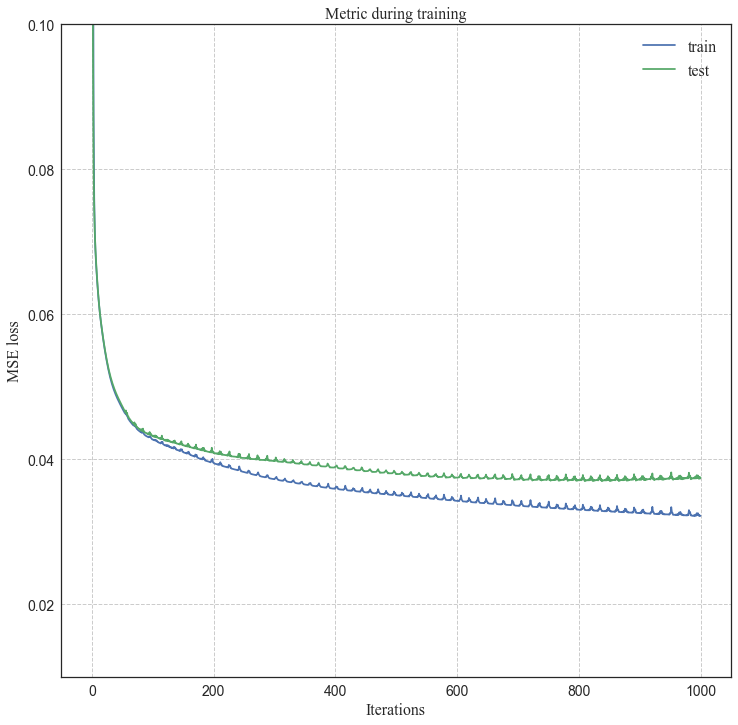

In [8]:
sns.set_style('white')
print('画出训练结果...')
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}
fig,ax = plt.subplots(figsize = (12,12))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.set_ylim(0.01, 0.1)

plt.ylabel('MSE loss',font)
plt.xlabel('Iterations',font)
plt.xticks(fontsize=14,fontweight='normal') #默认字体大小为10
plt.yticks(fontsize=14,fontweight='normal')
plt.grid(linestyle = '--')     # 添加网格线
plt.title('Metric during training',font)
plt.savefig('16.jpg',dpi=600, bbox_inches = 'tight')
plt.legend(loc='best',prop = font)
plt.show()

In [9]:
model.save('LSTM_model/lstm.h5')

In [10]:
#模型再训练(数据增强)
from keras.models import load_model
data_retrain = pd.read_csv("../data/data_retrain.csv")
data_retrain = data_retrain.dropna()
data_val = pd.read_csv("../data/data_val.csv")
data_val = data_val.dropna()
data_3 = data_val[:3600]
data = pd.concat([data_retrain,data_3])
print(data.shape)

(10954, 8)


In [11]:
data['soot'][:5]

0    0.070829
1    0.049862
2    0.345933
3    2.737220
4    4.008982
Name: soot, dtype: float64

In [12]:
data_la = data
data_la['soot'] = data_la['soot'].apply( lambda x: 0.1 if x<0.2 else x)
data_la['soot'] = np.log1p(data_la['soot'])

In [13]:
data_la['soot'][:5]

0    0.095310
1    0.095310
2    0.297087
3    1.318342
4    1.611233
Name: soot, dtype: float64

In [14]:
features =  data_la.columns.values[0:7]   
#data = data_la.drop(data_la[(data_la['soot']<0.2)].index)
data = data_la
n_train_days = int(len(data)*0.8)
data = data
#前80% 天的数据作为训练数据
train = data[:n_train_days]

#最后20%天的数据作为测试数据
test = data[n_train_days:]

In [15]:
train_X, train_y = train[features].values, train['soot'].values

test_X, test_y = test[features].values, test['soot'].values
from sklearn import  preprocessing
train_X = preprocessing.scale(train_X)
test_X = preprocessing.scale(test_X)
#数据转化为LSTM的输入数据类型（3D格式，【样本，时间步长，特征】）
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8763, 1, 7) (8763,) (2191, 1, 7) (2191,)


In [16]:
from keras.layers import BatchNormalization
from keras.models import Sequential
#model = Sequential()
model = load_model('LSTM_model/lstm.h5')
#model.add(BatchNormalization()) 
model.fit(train_X,train_y,batch_size = 360,epochs = 50,validation_data = (test_X,test_y))

Train on 8763 samples, validate on 2191 samples
Epoch 1/50
8763/8763 [==============================] - 0s 54us/step - loss: 0.5644 - mean_absolute_error: 0.5275 - val_loss: 0.3781 - val_mean_absolute_error: 0.4476
Epoch 2/50
8763/8763 [==============================] - 0s 13us/step - loss: 0.2911 - mean_absolute_error: 0.3801 - val_loss: 0.3421 - val_mean_absolute_error: 0.4314
Epoch 3/50
8763/8763 [==============================] - 0s 12us/step - loss: 0.2574 - mean_absolute_error: 0.3448 - val_loss: 0.3394 - val_mean_absolute_error: 0.4268
Epoch 4/50
8763/8763 [==============================] - 0s 12us/step - loss: 0.2434 - mean_absolute_error: 0.3330 - val_loss: 0.3292 - val_mean_absolute_error: 0.4217
Epoch 5/50
8763/8763 [==============================] - 0s 12us/step - loss: 0.2344 - mean_absolute_error: 0.3255 - val_loss: 0.3234 - val_mean_absolute_error: 0.4214
Epoch 6/50
8763/8763 [==============================] - 0s 13us/step - loss: 0.2277 - mean_absolute_error: 0.3199 - v

8763/8763 [==============================] - 0s 17us/step - loss: 0.1823 - mean_absolute_error: 0.2783 - val_loss: 0.3072 - val_mean_absolute_error: 0.4244
Epoch 50/50
8763/8763 [==============================] - 0s 12us/step - loss: 0.1822 - mean_absolute_error: 0.2785 - val_loss: 0.3126 - val_mean_absolute_error: 0.4312


In [17]:
train_y[:5]

array([0.09531018, 0.09531018, 0.29708746, 1.31834202, 1.61123268])

In [18]:
model.evaluate(test_X,test_y)

2191/2191 [==============================] - 0s 44us/step


[0.3126119430045568, 0.43116887990386993]

In [19]:
test_y[:5]

array([1.24158969, 1.17702771, 1.20089796, 1.18279856, 1.023906  ])

In [20]:
model.save('LSTM_model/lstm_rein2.h5')

In [21]:
#保存参数/加载参数
model.save_weights('LSTM_model/lstm_rein_weights2.h5')
model.load_weights('LSTM_model/lstm_rein_weights2.h5')

In [22]:
#保存网络结构
from keras.models import model_from_json
json_string = model.to_json()
model = model_from_json(json_string)
print(json_string)

{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "LSTM", "config": {"name": "lstm_1", "trainable": true, "batch_input_shape": [null, 1, 7], "dtype": "float32", "return_sequences": false, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "units": 30, "activation": "tanh", "recurrent_activation": "hard_sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "recurrent_initializer": {"class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "unit_forget_bias": true, "kernel_regularizer": null, "recurrent_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "recurrent_constraint": null, "bias_constraint": null, "dropout": 0.0, "recurrent_dropout": 0.0, "implementation": 1}}, {"class_name"

In [23]:
#计算预测值和实际值之间的均方根误差
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import load_model
test = pd.read_csv('../data/data_val_fin.csv')
features =  data_la.columns.values[0:7]   
test = test[features].values
from sklearn import  preprocessing
test = preprocessing.scale(test)
test = test.reshape((test.shape[0], 1, test.shape[1]))
model = load_model('LSTM_model/lstm_rein2.h5')
model.load_weights('LSTM_model/lstm_rein_weights2.h5')
predictions = model.predict(test)
rnn_pred = np.expm1(predictions)

In [24]:
print(len(rnn_pred))

6475


In [25]:
rnn_pred = rnn_pred.reshape(6475)
sub = pd.DataFrame()
sub['soot'] = rnn_pred
sub.to_csv('LSTM_model/submission2.csv',index=False)